# **Data Preprocessing**


## Import thư viện

In [1]:
# Thư viện xử lý
import os
import torch
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

# Thư viện cân bằng
from imblearn.over_sampling import SMOTE

# Thư viện chuẩn hóa
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

from concurrent.futures import ThreadPoolExecutor

In [6]:
os.listdir('/kaggle/input/')

['nsl-kdd']

## Gán Heading cho các cột feature

In [2]:
column_names = ["duration",
 "protocol_type",
 "service",
 "flag",
 "src_bytes",
 "dst_bytes",
 "land",
 "wrong_fragment",
 "urgent",
 "hot",
 "num_failed_logins",
 "logged_in",
 "num_compromised",
 "root_shell",
 "su_attempted",
 "num_root",
 "num_file_creations",
 "num_shells",
 "num_access_files",
 "num_outbound_cmds",
 "is_host_login",
 "is_guest_login",
 "count",
 "srv_count",
 "serror_rate",
 "srv_serror_rate",
 "rerror_rate",
 "srv_rerror_rate",
 "same_srv_rate",
 "diff_srv_rate",
 "srv_diff_host_rate",
 "dst_host_count",
 "dst_host_srv_count",
 "dst_host_same_srv_rate",
 "dst_host_diff_srv_rate",
 "dst_host_same_src_port_rate",
 "dst_host_srv_diff_host_rate",
 "dst_host_serror_rate",
 "dst_host_srv_serror_rate",
 "dst_host_rerror_rate",
 "dst_host_srv_rerror_rate",
 "attack_type",
 "attack_index"]

## Đọc file

In [3]:
df_train = pd.read_csv('/kaggle/input/nslkdd/KDDTrain.txt', names = column_names)
df_test = pd.read_csv('/kaggle/input/nslkdd/KDDTest.txt', names = column_names)

## Kiểm tra thông tin về tập dữ liệu

#### Xem thông tin về các cột đặc trưng

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

#### Kiểm tra giá trị null

In [9]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

#### Kiểm tra trùng lặp

In [6]:
df_train.duplicated().sum()

0

## Chuẩn hóa các đặc trưng chữ về kiểu dữ liệu số

### Phương pháp One-Hot Encoding

In [4]:
# Thêm cột "dataset" để phân biệt
df_train['dataset'] = 'train'
df_test['dataset'] = 'test'

# Kết hợp train và test
df_combined = pd.concat([df_train, df_test], axis=0)

# Áp dụng one-hot encoding
df_combined = pd.get_dummies(df_combined, columns=['protocol_type', 'service', 'flag'])

# Tách lại thành train và test
df_train = df_combined[df_combined['dataset'] == 'train'].drop('dataset', axis=1)
df_test = df_combined[df_combined['dataset'] == 'test'].drop('dataset', axis=1)

In [5]:
columns = df_train.columns
# Chuyển các kiểu dữ liệu bool thành binary
one_hot_columns = [col for col in columns if 'protocol_type_' in col or 'service_' in col or 'flag_' in col]
df_train[one_hot_columns] = df_train[one_hot_columns].astype(int)
df_test[one_hot_columns] = df_test[one_hot_columns].astype(int)

## Phân loại nhị phân

### Cân bằng tỷ lệ phân bố ở lớp nhãn, áp dụng Partial SMOTE (tăng nhẹ)

#### Xử lý lớp nhãn cho phân loại nhị phân

In [6]:
# Phân loại nhị phân
df_train['label'] = df_train['attack_type'].apply(lambda x: 'anomaly' if x != 'normal' else 'normal')
df_test['label'] = df_test['attack_type'].apply(lambda x: 'anomaly' if x != 'normal' else 'normal')

# Chuyển giá trị từ 'normal' và 'anomaly' -> binary '0', '1'
df_train["label"] = df_train["label"].map({'normal': 0, 'anomaly': 1})
df_test['label'] = df_test['label'].map({'normal': 0, 'anomaly': 1})

#### Tách lớp nhãn

In [7]:
# Tách lớp nhãn để xử lý
output_data_train = df_train['label']
output_data_test = df_test['label']

# Tách lớp nhãn để tiền xử lý
df_train = df_train.drop(columns=['label','attack_type'])
df_test = df_test.drop(columns=['label','attack_type'])

#### Cân bằng lớp nhãn

In [8]:
# Thực hiện smote tăng các giá trị thấp để cân bằng
smote = SMOTE(random_state=42)
df_train_resampled, label_resampled = smote.fit_resample(df_train, output_data_train)
df_label_balanced = pd.concat([pd.DataFrame(df_train_resampled, columns=df_train.columns), 
                               pd.Series(label_resampled, name='label')], axis=1)

output_data_train = df_label_balanced["label"]

df_train = df_label_balanced.drop(columns=['label'])

In [8]:
output_data_train.value_counts()

label
0    67343
1    58630
Name: count, dtype: int64

## Phân loại đa lớp

### Xử lý lớp nhãn

UNSW-NB15 có 1 loại normal và 4 loại tấn công chính:
- DoS
- Probe
- R2L
- U2R
Theo nghiên cứu "A Study on NSL-KDD Dataset for Intrusion
Detection System Based on Classification Algorithms" có các loại tấn công tại đặc trưng attack_type

In [6]:
# Phân bổ các loại tấn công theo nhóm chính
def encode_label(attack_type):
    if attack_type == 'normal':
        return 0  # Normal
    elif attack_type in ['neptune', 'smurf', 'teardrop', 'back', 'pod', 'land', 'apache2',
                         'udpstorm', 'processtable', 'worm', 'mailbomb']:
        return 1  # DoS
    elif attack_type in ['ipsweep', 'portsweep', 'satan', 'nmap', 'mscan', 'saint']:
        return 2  # Probe
    elif attack_type in ['warezclient', 'guess_passwd', 'imap', 'ftp_write',
                         'warezmaster', 'multihop', 'spy', 'phf', 'xlock', 'xsnoop',
                         'snmpguess', 'snmpgetattack',
                         'httptunnel', 'sendmail', 'named']:
        return 3  # R2L
    elif attack_type in ['buffer_overflow', 'rootkit', 'loadmodule', 'perl', 'sqlattack',
                         'xterm', 'ps']:
        return 4  # U2R

# Áp dụng mã hóa cho cả tập train và test
df_train['label'] = df_train['attack_type'].apply(encode_label)
df_test['label'] = df_test['attack_type'].apply(encode_label)
df_test['label'] = df_test['label'].astype('int64')

df_train = df_train.drop(columns=['attack_type'])

output_data_test = df_test['label']
df_test = df_test.drop(columns=['attack_type', 'label'])

In [7]:
output_data_train = df_train['label']
df_train = df_train.drop(columns=['label'])

In [10]:
output_data_train.value_counts()

label
0    67343
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

In [9]:
output_data_test.value_counts()

label
0    9711
1    7460
3    2885
2    2421
4      67
Name: count, dtype: int64

### Cân bằng lớp nhãn đa lớp

In [7]:
# Tạo đối tượng SMOTE
smote = SMOTE(sampling_strategy={3: 2000, 4: 1000}, random_state=42)  # Oversample lớp R2L và U2R đến 5000 mẫu

X_train = df_train.drop(columns=["label"])
y_train = df_train["label"]

# Áp dụng SMOTE
df_train, output_data_train = smote.fit_resample(X_train, y_train)

In [56]:
output_data_train.value_counts()

label
0    67343
1    45927
2    11656
3     2000
4     1000
Name: count, dtype: int64

## Kiểm tra các đặc trưng quan trọng

In [8]:
# Khởi tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(df_train, output_data_train)

# Lấy mức độ quan trọng của các feature
importances = model.feature_importances_

# Tạo output để dễ dàng nhìn thấy kết quả
feature_importance_df = pd.DataFrame({
    'Feature': df_train.columns,
    'Importance': importances
})

# Sắp xếp các feature theo mức độ quan trọng
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [10]:
feature_importance_df[:60]

,Feature,Importance
1,src_bytes,0.132716
2,dst_bytes,0.114292
25,same_srv_rate,0.082743
121,flag_SF,0.075034
30,dst_host_same_srv_rate,0.063783
38,attack_index,0.053346
19,count,0.039771
26,diff_srv_rate,0.038779
8,logged_in,0.034600
31,dst_host_diff_srv_rate,0.031309


## Thực hiện nhân bản một số đặc trưng quan trọng

### Kiểm tra số cột đặc trưng đang có

### Lấy một số đặc trưng nhân bản

In [9]:
num_features = 50

In [10]:
feature_importance_50 = feature_importance_df[:num_features]

### Thực hiện nhân bản


In [9]:
df_train.shape[1]

123

In [11]:
important_features = feature_importance_50['Feature'].tolist()

# Tính toán số lượng cần nhân bản
# Ví dụ số lượng đặc trưng chọn nhân bản: 50
# num_copies = (1024 - 123) // 50 = 18 lần
# remainder = (1024 - 123) // 50 = 1 (có 1 đặc trưng nhân bản thêm 1 lần)

num_copies = (1024 - 123) // len(important_features)
remainder = (1024 - 123) % len(important_features)

# --------- Xử lý nhân bản các đặc trưng cho tập train---------
expanded_features_list = []
for feature in important_features:
    for _ in range(num_copies):
        expanded_features_list.append(df_train[feature].rename(f"{feature}_copy_{_}"))

# Phân phối phần còn lại
for i in range(remainder):
    feature = important_features[i]
    expanded_features_list.append(df_train[feature].rename(f"{feature}_extra_copy"))

expanded_features_train = pd.concat([df_train] + expanded_features_list, axis=1)
df_train = expanded_features_train.iloc[:, :1024]

# ------- Nhân bản các đặc trưng quan trọng cho tập test-----------
expanded_features_list_test = []

for feature in important_features:
    for _ in range(num_copies):
         expanded_features_list_test.append(df_test[feature].rename(f"{feature}_copy_{_}"))

# Phân phối phần còn lại
for i in range(remainder):
    feature = important_features[i]
    expanded_features_list_test.append(df_test[feature].rename(f"{feature}_extra_copy"))

# Gộp tất cả cột mới vào DataFrame ban đầu
expanded_features_test = pd.concat([df_test] + expanded_features_list_test, axis=1)
df_test = expanded_features_test.iloc[:, :1024]  # Chỉ lấy 1024 cột

In [12]:
df_train.shape[-1]

1024

## Áp dụng MinMaxScaler() đưa dữ liệu về cùng quy mô

In [12]:
# scaler_Min_Max = MinMaxScaler(feature_range=(0, 255))
# # scaler_Standard = Stand ardScaler()

# input_data_train = scaler_Min_Max.fit_transform(df_train)
# input_data_test = scaler_Min_Max.transform(df_test)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

input_data_train  = scaler.fit_transform(df_train)
input_data_test = scaler.transform(df_test)

In [17]:
input_data_train[:20]

array([[-0.11108732, -0.00796106, -0.00503763, ..., -0.01249638,
        -0.01249638, -0.00796106],
       [-0.11108732, -0.00802028, -0.00503763, ..., -0.01249638,
        -0.01249638, -0.00802028],
       [-0.11108732, -0.00804534, -0.00503763, ..., -0.01249638,
        -0.01249638, -0.00804534],
       ...,
       [-0.11108732, -0.00804225, -0.00503763, ..., -0.01249638,
        -0.01249638, -0.00804225],
       [-0.11108732, -0.00800535, -0.00488327, ..., -0.01249638,
        -0.01249638, -0.00800535],
       [-0.11108732, -0.00798647, -0.00474245, ..., -0.01249638,
        -0.01249638, -0.00798647]])

# **Chuyển đổi tập dữ liệu thành ảnh**


In [14]:
import os
import random
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

## Hàm chuyển đổi dữ liệu thành ảnh

### Xử lý hình ảnh 32x32

In [15]:
def convert_and_save_image(row, index, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    if len(row) < 1024:
        padded_row = np.pad(row, (0, 1024 - len(row)), mode='constant', constant_values=0)
    else:
        padded_row = row[:1024]  # Cắt bỏ phần thừa

    normalized_row = (padded_row - np.min(padded_row)) / (np.max(padded_row) - np.min(padded_row)) 
    scaled_row = normalized_row * 255
    
    # Hình thành ma trận kích thước 32x32
    image_data_reshaped = scaled_row.reshape((32, 32))

    # Tạo ảnh màu với 3 kênh
    image_rgb = np.stack([image_data_reshaped] * 3, axis=-1)

    image = Image.fromarray(image_rgb.astype(np.uint8))
    image_path = os.path.join(output_dir, f"image{index}.jpg")
    try:
        image.save(image_path)
    except Exception as e:
        print(f"Lỗi thao tác {index}: {e}")

## Thực hiện xử lý đa luồng

In [16]:
def process_dataset(dataset, output_dir):
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(convert_and_save_image, row, i, output_dir) for i, row in enumerate(dataset)]
        for future in futures:
            future.result()

## Trích ra số lượng mẫu

### Phân loại nhị phân

#### Trích mẫu số lượng nhỏ

Lấy ra lớp nhãn 0 và 1 của tập train và test

In [17]:
# Lớp nhãn 0 và 1 của tập train
train_normal = list(np.where(output_data_train == 0)[0])
train_anomaly = list(np.where(output_data_train == 1)[0])

# Lớp nhãn 0 và 1 của tập test
test_normal = list(np.where(output_data_test == 0)[0])
test_anomaly = list(np.where(output_data_test == 1)[0])

Trích ra số lượng mẫu

In [53]:
# Random ngẫu nhiên mẫu
np.random.seed(42)
random.seed(42)

# Trích ra một số mẫu để kiểm thử
data_train_normal = input_data_train[random.sample(train_normal, 30000)]
data_train_anomaly = input_data_train[random.sample(train_anomaly, 20000)]
data_test_normal = input_data_test[random.sample(test_normal, 2300)]
data_test_anomaly = input_data_test[random.sample(test_anomaly, 4000)]

#### Lấy hết tập dữ liệu



In [18]:
data_train_normal = input_data_train[train_normal]
data_train_anomaly = input_data_train[train_anomaly]
data_test_normal = input_data_test[test_normal]
data_test_anomaly = input_data_test[test_anomaly]

#### Xử lý và lưu trữ ảnh

In [19]:
train_normal_dir = "/kaggle/working/nsl_kdd/train/normal/"
train_anomaly_dir = "/kaggle/working/nsl_kdd/train/anomaly/"
test_normal_dir = "/kaggle/working/nsl_kdd/test/normal/"
test_anomaly_dir = "/kaggle/working/nsl_kdd/test/anomaly/"

process_dataset(data_train_normal, train_normal_dir)
process_dataset(data_train_anomaly, train_anomaly_dir)
process_dataset(data_test_normal, test_normal_dir)
process_dataset(data_test_anomaly, test_anomaly_dir)

### Phân loại đa lớp

#### Trích mẫu số lượng nhỏ

In [17]:
# Lọc các giá trị tương ứng {0, 1, 2, 3, 4} -> "Normal", "DoS", "Probe", "R2L", "U2R"
train_normal = list(np.where(output_data_train == 0)[0])
train_dos = list(np.where(output_data_train == 1)[0])
train_probe = list(np.where(output_data_train == 2)[0])
train_r2l = list(np.where(output_data_train == 3)[0])
train_u2r = list(np.where(output_data_train == 4)[0])

test_normal = list(np.where(output_data_test == 0)[0])
test_dos = list(np.where(output_data_test == 1)[0])
test_probe = list(np.where(output_data_test == 2)[0])
test_r2l = list(np.where(output_data_test == 3)[0])
test_u2r = list(np.where(output_data_test == 4)[0])

Trích ra số lượng mẫu

In [22]:
train_per_label = 8000 # số lượng mẫu huấn luyện
test_per_label = 2000  # số lượng mẫu kiểm thử

In [19]:
# Chọn mẫu ngẫu nhiên từ mỗi lớp
np.random.seed(42)
random.seed(42)

# Chọn mẫu cho tập huấn luyện
data_train_normal = input_data_train[random.sample(train_normal, 18000)]
data_train_dos = input_data_train[random.sample(train_dos, 10000)]
data_train_probe = input_data_train[random.sample(train_probe, 4500)]
data_train_r2l = input_data_train[random.sample(train_r2l, 2000)]
data_train_u2r = input_data_train[random.sample(train_u2r, 1500)]

# Chọn mẫu cho tập kiểm tra
data_test_normal = input_data_test[random.sample(test_normal, test_per_label)]
data_test_dos = input_data_test[random.sample(test_dos, test_per_label)]
data_test_probe = input_data_test[random.sample(test_probe, test_per_label)]
data_test_r2l = input_data_test[random.sample(test_r2l, test_per_label)]
data_test_u2r = input_data_test[test_u2r] # U2R có 37 mẫu

Lấy hết mẫu để huấn luyện

In [18]:
# Chọn mẫu cho tập huấn luyện
data_train_normal = input_data_train[train_normal]
data_train_dos = input_data_train[train_dos]
data_train_probe = input_data_train[train_probe]
data_train_r2l = input_data_train[train_r2l]
data_train_u2r = input_data_train[train_u2r]

# Chọn mẫu cho tập kiểm tra
data_test_normal = input_data_test[test_normal]
data_test_dos = input_data_test[test_dos]
data_test_probe = input_data_test[test_probe]
data_test_r2l = input_data_test[test_r2l]
data_test_u2r = input_data_test[test_u2r]

#### Xử lý và lưu trữ ảnh

In [19]:
# Đường dẫn thư mục huấn luyện, kiểm thử
train_normal_dir = "/kaggle/working/nsl_kdd/train/normal/"
train_dos_dir = "/kaggle/working/nsl_kdd/train/DoS/"
train_probe_dir = "/kaggle/working/nsl_kdd/train/Probe/"
train_r2l_dir = "/kaggle/working/nsl_kdd/train/R2L/"
train_u2r_dir = "/kaggle/working/nsl_kdd/train/U2R/"

test_normal_dir = "/kaggle/working/nsl_kdd/test/normal/"
test_dos_dir = "/kaggle/working/nsl_kdd/test/DoS/"
test_probe_dir = "/kaggle/working/nsl_kdd/test/Probe/"
test_r2l_dir = "/kaggle/working/nsl_kdd/test/R2L/"
test_u2r_dir = "/kaggle/working/nsl_kdd/test/U2R/"

# Thực hiện xử lý và lưu trữ ảnh
process_dataset(data_train_normal, train_normal_dir)
process_dataset(data_train_dos, train_dos_dir)
process_dataset(data_train_probe, train_probe_dir)
process_dataset(data_train_r2l, train_r2l_dir)
process_dataset(data_train_u2r, train_u2r_dir)

process_dataset(data_test_normal, test_normal_dir)
process_dataset(data_test_dos, test_dos_dir)
process_dataset(data_test_probe, test_probe_dir)
process_dataset(data_test_r2l, test_r2l_dir)
process_dataset(data_test_u2r, test_u2r_dir)

## Kiểm tra ảnh đã chuyển từ dữ liệu

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Hiển thị ảnh

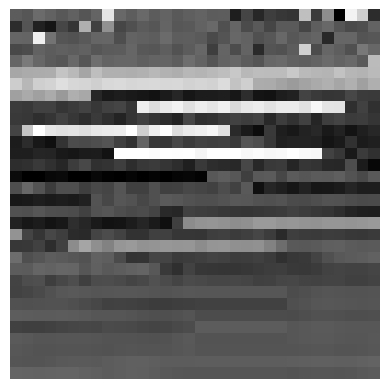

In [28]:
image_path = '/kaggle/working/nsl_kdd/train/normal/image5.jpg'
img = mpimg.imread(image_path)

# Hiển thị ảnh màu
plt.imshow(img)
plt.axis('off') # Ẩn trục
plt.show()

### Kiểm tra số lượng kênh

In [29]:
# Kiểm tra số kênh của ảnh
print("Số chiều của ảnh:", img.ndim)
print("Hình dạng của ảnh:", img.shape)

Số chiều của ảnh: 3
Hình dạng của ảnh: (32, 32, 3)


# Mô hình Vision Transformer

In [20]:
import torch
import shutil
import numpy as np
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

from transformers import AutoModelForImageClassification, ViTConfig

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

train_dir = "/kaggle/working/nsl_kdd/train/"
test_dir = "/kaggle/working/nsl_kdd/test/"

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"



mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_transforms_rgb = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    AddGaussianNoise(0.0, 0.05),
    transforms.Normalize(mean=mean, std=std)])


# Dữ liệu gốc từ thư mục
dataset = datasets.ImageFolder(root=train_dir)

# Chia tách dataset thành train và val
train_size = int(0.8 * len(dataset))  # 80% cho train
val_size = len(dataset) - train_size  # 20% cho validation
train_indices, val_indices = random_split(dataset, [train_size, val_size])

# Tạo các tập con với phép biến đổi riêng biệt
train_dataset = Subset(dataset, train_indices.indices)
train_dataset.dataset.transform = train_transforms_rgb
val_dataset = Subset(dataset, val_indices.indices)
val_dataset.dataset.transform = transform_rgb

# Lấy nhãn của các mẫu trong train_dataset
labels_train = [dataset.targets[i] for i in train_indices.indices]
labels_val = [dataset.targets[i] for i in val_indices.indices]

# Tạo DataLoader cho train và val
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataset_test = ImageFolder(root=test_dir, transform=transform_rgb)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


# ------ Khởi tạo mô hình ViT --------

config = ViTConfig.from_pretrained("WinKawaks/vit-small-patch16-224")
config.image_size = (32, 32)
config.patch_size = (8, 8)
config.num_channels = 3
config.num_labels = 2

model = AutoModelForImageClassification.from_config(config)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


# Khởi tạo đối tượng dừng khi mô hình bị quá khớp
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Mô hình bị overfiting")


# Hàm đánh giá trên tập test
def evaluate_test_set(test_loader, model):
    model.eval()  # Khởi tạo model đánh giá
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.logits, dim=1)  # Dự đoán lớp
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(preds.cpu().numpy())

    return all_labels, all_predictions

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

In [20]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

## Các thiết lập tối ưu

In [22]:
# Thêm Dropout vào classification head
model.classifier.dropout = torch.nn.Dropout(p=0.3) # Giữ lại _% nơ-ron

# Chuyển numpy array thành tensor
class_weights = compute_class_weight('balanced', classes=np.unique(labels_train), y=labels_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Chuyển sang tensor và chuyển đến device

# Định nghĩa hàm mất mát với trọng số lớp
criterion = torch.nn.CrossEntropyLoss(weight = class_weights) # Hàm mất mát cho phân loại

# Thiết lập bộ tối ưu với (lr - tốc độ, weight_decay - Regulation L2, L1)
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)  # Bộ tối ưu

# Điều chỉnh tốc độ học (learning rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                       patience=3, verbose=True)

In [36]:
print(labels_train)

[0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 

In [37]:
count_0, count_1 = 0, 0

for i in labels_train:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1

print(f"attack: {count_0}")
print(f"normal: {count_1}")

attack: 46968
normal: 53810


In [39]:
count_0, count_1 = 0, 0

for i in labels_val:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1

print(f"attack: {count_0}")
print(f"normal: {count_1}")

attack: 11662
normal: 13533


In [76]:
count_0, count_1, count_2, count_3, count_4 = 0, 0, 0, 0, 0

for i in labels_train:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1
    elif i == 2:
        count_2 += 1
    elif i == 3:
        count_3 += 1
    else:
        count_4 += 1

print(f"DoS: {count_0}")
print(f"Probe: {count_1}")
print(f"R2L: {count_2}")
print(f"U2R: {count_3}")
print(f"Normal: {count_4}")

DoS: 36708
Probe: 9349
R2L: 1611
U2R: 794
Normal: 53878


In [75]:
count_0, count_1, count_2, count_3, count_4 = 0, 0, 0, 0, 0

for i in labels_val:
    i = int(i)  # Chuyển giá trị thành kiểu int
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1
    elif i == 2:
        count_2 += 1
    elif i == 3:
        count_3 += 1
    else:
        count_4 += 1

print(f"DoS: {count_0}")
print(f"Probe: {count_1}")
print(f"R2L: {count_2}")
print(f"U2R: {count_3}")
print(f"Normal: {count_4}")

DoS: 9219
Probe: 2307
R2L: 389
U2R: 206
Normal: 13465


In [77]:
print(dataset.classes)

['DoS', 'Probe', 'R2L', 'U2R', 'normal']


In [78]:
class_weights

tensor([ 0.5576,  2.1893, 12.7052, 25.7783,  0.3799], device='cuda:0')

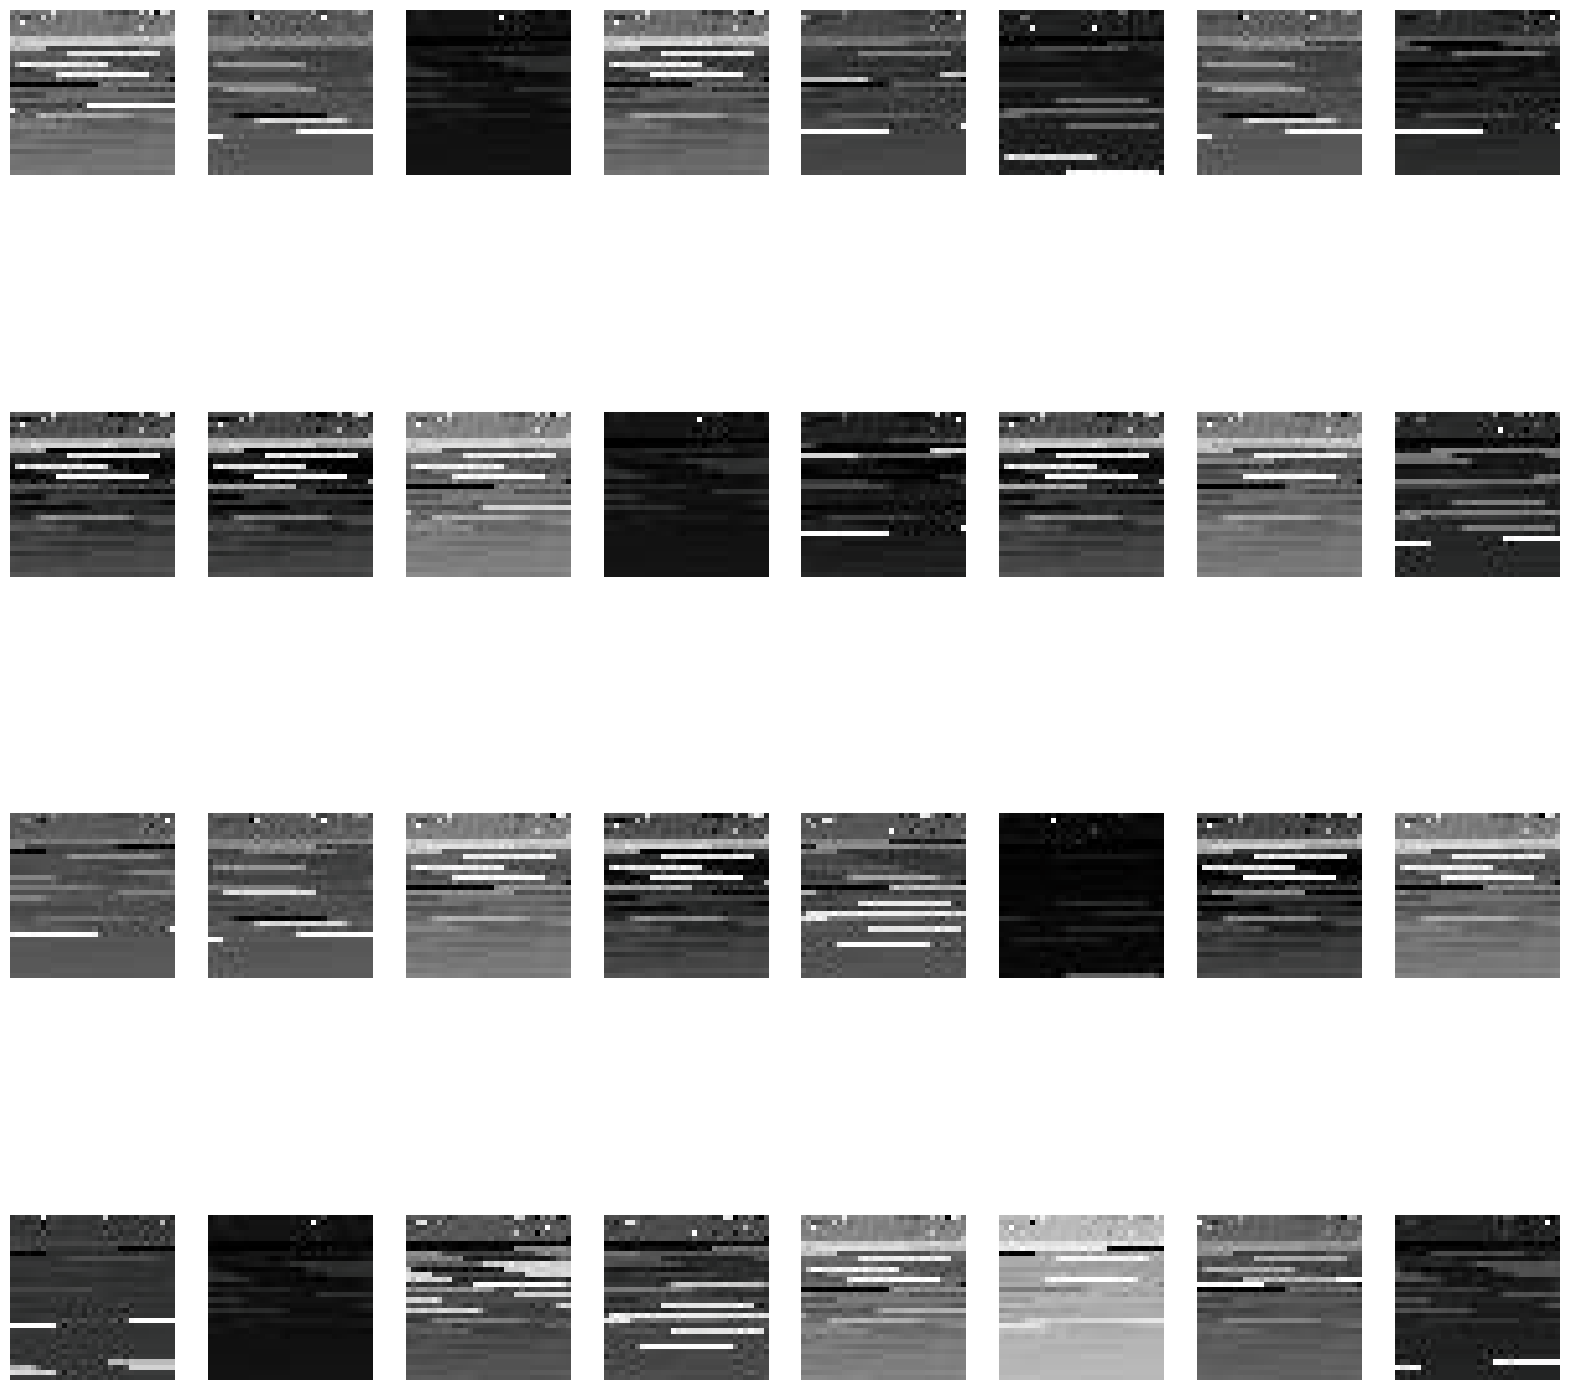

In [32]:
samples, labels = next(iter(train_loader))  # Lấy batch đầu tiên

def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

# Hiển thị ảnh
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

samples = [denormalize(img, mean, std) for img in samples]  # Đảo chuẩn hóa

num_images = len(samples)  # Số lượng các ảnh trong batch

# Thiết lập số hàng và cột cho grid (8 hàng, 4 cột)
cols = 8
rows = num_images // cols + (num_images % cols != 0)

plt.figure(figsize=(20, 20))
for i in range(num_images):
    img = samples[i].numpy().transpose(1, 2, 0)  # Chuyển từ CHW sang HWC để hiển thị
    plt.subplot(rows, cols, i + 1)  # Sắp xếp các ảnh thành grid
    plt.imshow(np.clip(img, 0, 1))  # Giới hạn giá trị trong [0, 1] để hiển thị đúng
    plt.axis("off")
plt.show()

## Huấn luyện và kiểm thử

### TH1: Phân loại nhị phân

In [23]:
import time

early_stopping = EarlyStopping(patience = 5, verbose=True)

num_epochs = 30 # Số vòng lặp huấn luyện
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Đặt lại gradient
        outputs = model(images)  # Dự đoán
        loss = criterion(outputs.logits, labels)  # Tính toán mất mát
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    
    # Validation
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Dự đoán
            loss = criterion(outputs.logits, labels)  # Tính toán mất mát
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    end_time = time.time()  # Kết thúc đo thời gian
    
    epoch_duration = end_time - start_time
    print(
        f"Epoch {epoch + 1}/{num_epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
        f"Time: {epoch_duration:.2f}s"
    )

    # Điểu chỉnh tốc độ học (learning rate)
    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
      break

Epoch 1/35 - Train Loss: 0.0833, Train Accuracy: 96.87%, Validation Loss: 0.0342, Validation Accuracy: 98.67%, Time: 146.22s
Epoch 2/35 - Train Loss: 0.0318, Train Accuracy: 98.83%, Validation Loss: 0.0201, Validation Accuracy: 99.21%, Time: 143.33s
Epoch 3/35 - Train Loss: 0.0245, Train Accuracy: 99.07%, Validation Loss: 0.0169, Validation Accuracy: 99.36%, Time: 143.07s
Epoch 4/35 - Train Loss: 0.0211, Train Accuracy: 99.20%, Validation Loss: 0.0143, Validation Accuracy: 99.50%, Time: 142.83s
Epoch 5/35 - Train Loss: 0.0185, Train Accuracy: 99.30%, Validation Loss: 0.0146, Validation Accuracy: 99.51%, Time: 142.39s
Epoch 6/35 - Train Loss: 0.0169, Train Accuracy: 99.38%, Validation Loss: 0.0118, Validation Accuracy: 99.59%, Time: 142.51s
Epoch 7/35 - Train Loss: 0.0157, Train Accuracy: 99.40%, Validation Loss: 0.0176, Validation Accuracy: 99.32%, Time: 142.34s
Epoch 8/35 - Train Loss: 0.0144, Train Accuracy: 99.45%, Validation Loss: 0.0102, Validation Accuracy: 99.63%, Time: 142.54s


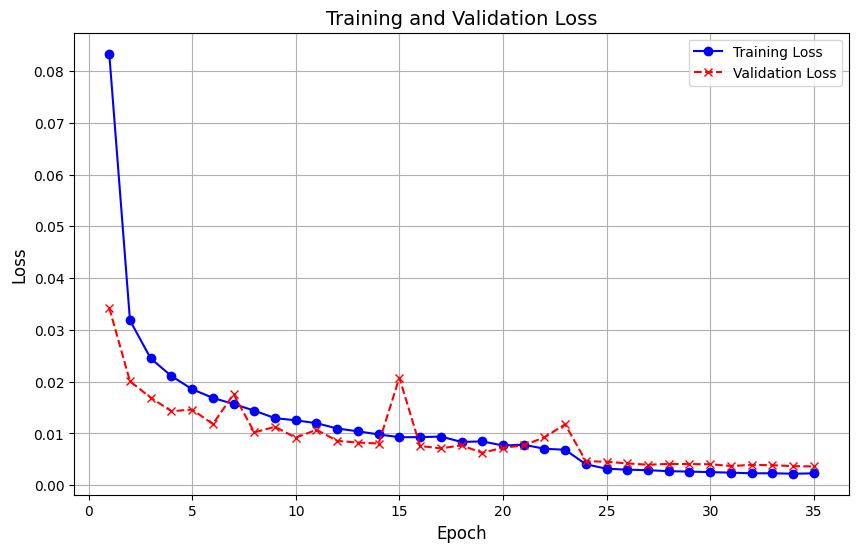

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))

# Vẽ đường cho Training Loss và Validation Loss với điểm đánh dấu
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', color='b')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x', linestyle='--', color='r')

# Thêm lưới
plt.grid(True)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.title("Training and Validation Loss", fontsize=14)

# Hiển thị chú thích
plt.legend()

plt.show()

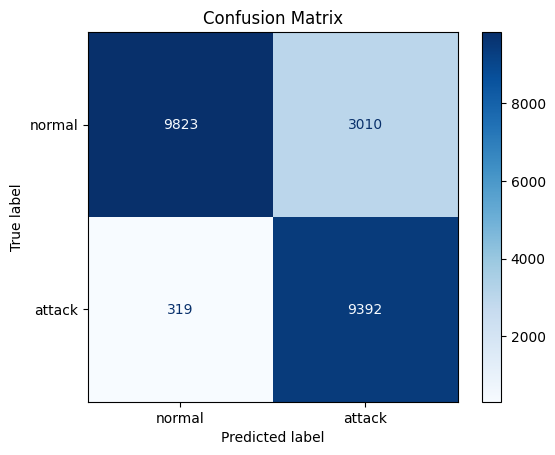

              precision    recall  f1-score   support

      attack       0.97      0.77      0.86     12833
      normal       0.76      0.97      0.85      9711

    accuracy                           0.85     22544
   macro avg       0.86      0.87      0.85     22544
weighted avg       0.88      0.85      0.85     22544



In [25]:
y_true, y_pred = evaluate_test_set(test_loader, model)

# Trực quan hóa Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Đánh giá kiểm thử
print(classification_report(y_true, y_pred, target_names=['attack', 'normal']))

### TH2: Phân loại đa lớp

In [22]:
import time

early_stopping = EarlyStopping(patience = 5, verbose=True)

num_epochs = 30 # Số vòng lặp huấn luyện

for epoch in range(num_epochs):
    model.train()  # Chuyển mô hình sang chế độ huấn luyện
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    start_time = time.time()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Đặt lại gradient
        outputs = model(images)  # Dự đoán
        loss = criterion(outputs.logits, labels)  # Tính toán mất mát
        loss.backward()  # Lan truyền ngược
        optimizer.step()  # Cập nhật trọng số

        running_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Validation
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Dự đoán
            loss = criterion(outputs.logits, labels)  # Tính toán mất mát
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    end_time = time.time()  # Kết thúc đo thời gian
    
    epoch_duration = end_time - start_time
    print(
        f"Epoch {epoch + 1}/{num_epochs} - "
        f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
        f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, "
        f"Time: {epoch_duration:.2f}s"
    )

    # Điểu chỉnh tốc độ học (learning rate)
    scheduler.step(val_loss)

    early_stopping(val_loss)
    if early_stopping.early_stop:
      break

Epoch 1/30 - Train Loss: 0.3478, Train Accuracy: 91.42%, Validation Loss: 0.1759, Validation Accuracy: 96.95%, Time: 146.08s
Epoch 2/30 - Train Loss: 0.1590, Train Accuracy: 96.62%, Validation Loss: 0.1330, Validation Accuracy: 97.96%, Time: 142.98s
Epoch 3/30 - Train Loss: 0.1274, Train Accuracy: 97.39%, Validation Loss: 0.1098, Validation Accuracy: 98.27%, Time: 142.25s
Epoch 4/30 - Train Loss: 0.1118, Train Accuracy: 97.86%, Validation Loss: 0.0875, Validation Accuracy: 98.56%, Time: 142.02s
Epoch 5/30 - Train Loss: 0.0987, Train Accuracy: 98.10%, Validation Loss: 0.0763, Validation Accuracy: 98.79%, Time: 142.79s
Epoch 6/30 - Train Loss: 0.0906, Train Accuracy: 98.19%, Validation Loss: 0.0813, Validation Accuracy: 99.01%, Time: 143.49s
Epoch 7/30 - Train Loss: 0.0815, Train Accuracy: 98.45%, Validation Loss: 0.0648, Validation Accuracy: 99.09%, Time: 142.64s
Epoch 8/30 - Train Loss: 0.0726, Train Accuracy: 98.51%, Validation Loss: 0.0694, Validation Accuracy: 98.96%, Time: 143.30s


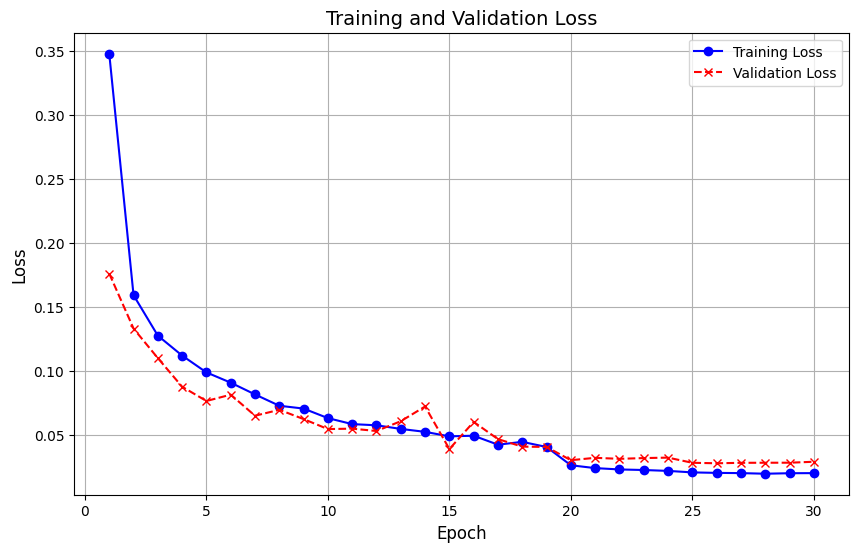

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))

# Vẽ đường cho Training Loss và Validation Loss với điểm đánh dấu
plt.plot(epochs, train_losses, label="Training Loss", marker='o', linestyle='-', color='b')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x', linestyle='--', color='r')

# Thêm lưới
plt.grid(True)

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

plt.title("Training and Validation Loss", fontsize=14)

# Hiển thị chú thích
plt.legend()

plt.show()

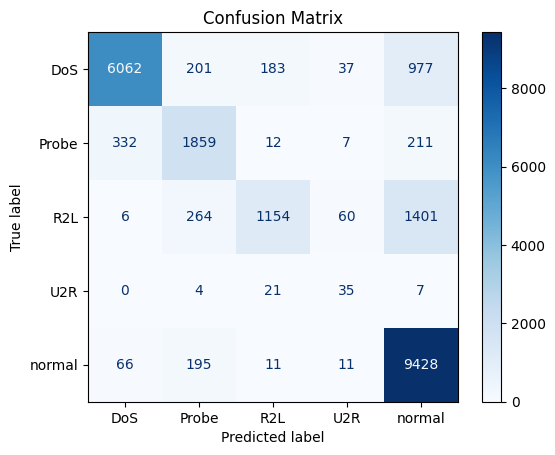

              precision    recall  f1-score   support

         DoS       0.94      0.81      0.87      7460
       Probe       0.74      0.77      0.75      2421
         R2L       0.84      0.40      0.54      2885
         U2R       0.23      0.52      0.32        67
      normal       0.78      0.97      0.87      9711

    accuracy                           0.82     22544
   macro avg       0.71      0.69      0.67     22544
weighted avg       0.83      0.82      0.81     22544



In [34]:
y_true, y_pred = evaluate_test_set(test_loader, model)

# Trực quan hóa Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DoS', 'Probe', 'R2L', 'U2R', 'normal'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Đánh giá kiểm thử
print(classification_report(y_true, y_pred, target_names=['DoS', 'Probe', 'R2L', 'U2R', 'normal']))